In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import json
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/mom6-regional-scripts")
import regional_library as ml
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38897,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:41237,Total threads: 2
Dashboard: /proxy/42439/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:35849,


In [2]:
expt_name = "sharkbay"
home_dir = "/home/581/jr5971/"
scratch = "/scratch/v45/jr5971/"

# set paths
## Directory where you'll run the experiment from
rundir = f'{home_dir}mom6_rundirs/{expt_name}/'
## Place where all your input files go
inputdir = f'{scratch}mom6/regional_configs/{expt_name}/'
## Place where temporary files are saved
tmpdir = f'{scratch}mom6/regional_tmp/{expt_name}/'

In [3]:
os.chdir(home_dir+'reg-scripts/')
from access_slicing import open_ryf_global, select_slice, time_rotate

# Demonstration of Regional Pipeline

This notebook is designed to showcase where we're up to so far. By the end you should have a running mom6 experiment on the domain of your choice. To make a stable test case:

* Keep your domain fairly small (my test case is a rectangle around Tasmania). If you go bigger you'll need to do some FRE tool shenannigens as explained in step 5 to get it working.  
* Avoid any regions with ice
* Avoid regions near the north pole
* Although the default configuration is meant to be RYF, I've not fixed up the calendar and encoding to run longer than a year just yet
* If you choose to do OM2-01 forcing, set your start date to 1990-01-01 which is what I've got it hardcoded to in step 2 option 2. 

Also hgrid is currently **not** mercator. It's equally spaced lat/long. To be updated very soon.


Input Type | Source
---|---
Surface | JRA
Ocean | GLORYS reanalysis product OR ACCESS OM2-01
Bathymetry | Gebco

# Step 1: Choose our domain, define workspace paths

**Option 1 - Interactive map**

So, here I (JR) have added an option to select the domain based on an interactive box drawn on a map. This uses functionality from `ipyleaflet` and `xarray_leaflet`. Steps are:
1. load in global data (bathymetry [`ht`] in this case
2. Roughly select the part of the world you're working in (I've just chosen the Australian region) NOTE: this could be skipped but it's just easier to zoom in as there are currently some funny things happening when you don't.
3. Slice the global data with the rough boundaries of the broader region (and rename coords to y, x.
4. Set up map (can select the rough center of the map, as well as the zoom. Additionally can change basemap.
5. Add the layer to the map and select the model domain. Currently the layer is not being plotted on the map, but the box is saved nonetheless so at the moment I'm happy leaving this as is. 

**Option 2 - Static Map**
The alternative to selecting the domain is to plot the broader region again, and select/adjust the model domain coords based on the box (matplotlib.patches) drawn on the map. 

So, here I want to load in a geospatial map of the oceans around Australia (we can make it global later if we really want). 

### Option 1 - Interactive Map

In [5]:
%%capture
!pip install xarray_leaflet
import xarray_leaflet
from ipyleaflet import Map, basemaps, LayersControl, WidgetControl, basemap_to_tiles

In [6]:
%%time
gridpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_grid.nc"
glob = xr.open_dataset(gridpath)['ht'].rename({'yt_ocean':'y','xt_ocean':'x'})
aus_coords = {'W':-270,'E':-170,'S':-50,'N':0}
ausmap = glob.sel(x=slice(aus_coords['W'],aus_coords['E']), y=slice(aus_coords['S'], aus_coords['N']))
ausmap

CPU times: user 2.55 s, sys: 1.22 s, total: 3.78 s
Wall time: 5.76 s


<xarray.DataArray 'ht' (y: 579, x: 1000)>
[579000 values with dtype=float32]
Coordinates:
  * x         (x) float64 -269.9 -269.8 -269.7 -269.6 ... -170.2 -170.1 -170.0
  * y         (y) float64 -49.96 -49.9 -49.83 -49.77 ... -0.35 -0.25 -0.15 -0.05
    geolon_t  (y, x) float32 ...
    geolat_t  (y, x) float32 ...
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid

In [8]:
m = Map(center=[-30,160], zoom=3, basemap=basemaps.Esri.WorldImagery)
layer = ausmap.leaflet.plot(m)
ausmap.leaflet.select()
m

Url()

Map(center=[-30, 160], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

The `select()` method above allows to select a region by clicking and dragging a box on the map (first click on the █ button).

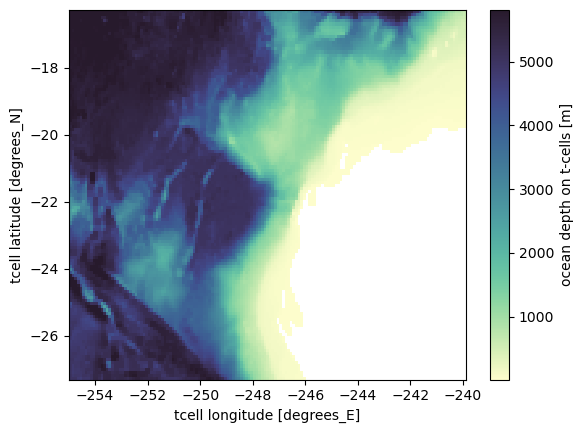

In [10]:
box = ausmap.leaflet.get_selection()
if box is not None:
    box.plot.imshow(cmap=cm.cm.deep)

In [11]:
idx = {'W':np.float(box.x[0]), 'E':np.float(box.x[-1]), 
       'S':np.float(box.y[-1]), 'N':np.float(box.y[0])}
# Save domain coordinates for future traceback
json_string = json.dumps(idx)
with open(tmpdir+'reg_coords.txt', 'w') as file:
    file.write(json_string)
idx

{'W': -254.94999999999465,
 'E': -239.9499999999955,
 'S': -27.259328374100818,
 'N': -16.32455195620721}

### Option 2 - Static Map

In [ ]:
from matplotlib import patches

In [ ]:
gridpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_grid.nc"
glob = xr.open_dataset(gridpath)['ht']
aus_coords = {'W':-270,'E':-170,'S':-50,'N':0}
ausmap = glob.sel(xt_ocean=slice(aus_coords['W'],aus_coords['E']), yt_ocean=slice(aus_coords['S'], aus_coords['N']))
fig, ax = plt.subplots()
ausmap.plot()
# box around sharkbay domain
idx = {'W':-255, 'E':-244, 'S':-28, 'N':-20}
shark_box = patches.Rectangle((idx['W'],idx['S']),(idx['E']-idx['W']),
                              (idx['N']-idx['S']), fill=False, edgecolor='r')
ax.add_patch(shark_box)

## 1.2 Setting up Paths
So, in setting up the various paths, how many are there, and what are there locations?
1. run directory - where the model configuration sits
- 'home_directory' + mom6_rundirs/expt_name...
2. input directory - where all the input files are to be saved to
- 'scratch directory' + mom6/regional_configs/expt_name...
3. temporary directory - where temporary files are saved for this pipeline..
- 'scratch directory' + mom6/regional_tmp/expt_name...

In [4]:
reload(ml)

for path in [rundir, inputdir, tmpdir]:
    try:
        os.makedirs(path)
        print(f'created directory: {path}')
    except:
        print(f'{path} already exists')
        pass
    
try: 
    idx
    print(f'index already exists')
except:
    with open(tmpdir + 'reg_coords.txt','r') as file:
        idx_string = file.read()
    idx = json.loads(idx_string)
    print('found model coords')


## Choose your coordinates and the name of your experiment
yextent = [idx['S'],idx['N']]  ## latitude
xextent = [idx['W'], idx['E']] ## longitude

# daterange = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"]

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables


/home/581/jr5971/mom6_rundirs/sharkbay/ already exists
/scratch/v45/jr5971/mom6/regional_configs/sharkbay/ already exists
/scratch/v45/jr5971/mom6/regional_tmp/sharkbay/ already exists
found model coords


# Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" and "ic_inprocessed" for initial condition. Execute either of the following cells to pick GLORYs reanalysis or ACCESS OM2-01

## Option1: GLORYs
The following cell generates a bash script in your designated 'temporary directory'. This should be on scratch somewhere and just a container for your raw donloads.

To do this you'll need to register with the Copernicus data centre to get a username and password. Fill these in below.

After executing, navigate to this directory in your terminal and run 'bash get_oceanfiles.sh'. Wait for all of your forcing segments to appear before continuing with the 'ocean forcing' step

In [ ]:
## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/regional_tmp/{expt_name}/"

pwd = "YOUR COPERNICUS PASSWORD"    
usr = "YOUR COPERNICUS USERNAME"    

file = open(f"{tmpdir}/get_oceanfiles.sh","w")
file.write(
        ml.motu_requests(xextent, yextent, daterange, tmpdir, usr, pwd,["north","south","east","west"])
)
file.close()


## Option 2: ACCESS OM2-01

If you have access to where it's located on Gadi, you can execute the following cell to cut out and save your segments and use these instead.

**NOTE: I haven't automated this properly. You'll need to fiddle around with the 'for i in range(1077,1082)' line to choose the right year. Could maybe use COSIMA cookbook for this step instead?**

So, I've made a few changes here, 
1. re-worked the file grab step - added some specified chunking here. This is hardly optimised but it is quicker doing this larger chunking here, rather than 'auto'. The thought is that we select very big chunks when opening the global data, and by the time we subset down to the slice we want, our chunk size is somewhere on O(100)MB. Note, I learnt that trying chunk in time from the outset does not work, as the largest chunk size is constrained by the length of that coordinate in the netcdf file (i.e., for time, each netcdf is saved in 3-monthly intervals, so the max chunking in time is ~90 days). 
2. Decided not to use the nicer_slicer - This made the saving step take at least 4-5 times longer for a single variable compared to the old approach of selecting a buffer around the slice (e.g., temperature for east boundary took 16 minutes compared to 3 minutes)

In [5]:
%%time
input_vars = ["u","v","salt","temp","eta_t"]
run_year=2170

om2_input = open_ryf_global()[input_vars]
# western boundary
west = select_slice(d = om2_input, borders = [yextent, xextent], boundary = 'west')
west

CPU times: user 4.96 s, sys: 836 ms, total: 5.79 s
Wall time: 13.6 s


<xarray.Dataset>
Dimensions:   (time: 456, st_ocean: 75, yu_ocean: 139, xu_ocean: 4,
               yt_ocean: 140, xt_ocean: 5)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -255.6 -255.5 -255.4 -255.3 -255.2
  * yt_ocean  (yt_ocean) float64 -28.41 -28.32 -28.23 ... -15.75 -15.65 -15.56
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2170-04-01 12:00:00 ... 2171-06-30 12:00:00
  * xu_ocean  (xu_ocean) float64 -255.6 -255.5 -255.4 -255.3
  * yu_ocean  (yu_ocean) float64 -28.36 -28.28 -28.19 ... -15.8 -15.7 -15.6
Data variables:
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(91, 75, 139, 4), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(91, 75, 139, 4), meta=np.ndarray>
    salt      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(91, 75, 140, 5), meta=np.ndarray>
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(91, 75, 140, 5), meta=np.ndarray>
    eta_t     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(91, 140, 5), meta=np.ndarray>
Attributes:
    filename:   ocean_daily_3d_dzt.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1

In [6]:
%%time
west = time_rotate(west.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).chunk({'time':-1})
west.to_netcdf(tmpdir+'west_unprocessed.nc')

CPU times: user 7.34 s, sys: 1.07 s, total: 8.41 s
Wall time: 1min 10s


In [19]:
%%time
input_vars = ["u","v","salt","temp","eta_t"]
run_year=2170

om2_input = open_ryf_global()[input_vars]
ic = time_rotate(om2_input.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).isel(time=0)
ic = ic.sel(
    yt_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    yu_ocean = slice(yextent[0]-0.2, yextent[1]+0.2)
    # xt_ocean = slice(xextent[0]-0.2, xextent[1]+0.2),
    # xu_ocean = slice(xextent[0]-0.2, xextent[1]+0.2)
)
ic = ml.nicer_slicer(ic, [xextent[0], xextent[1]], ["xu_ocean","xt_ocean"])
ic
# ic.to_netcdf(tmpdir+'ic_unprocessed.nc')

CPU times: user 4.1 s, sys: 228 ms, total: 4.33 s
Wall time: 5.06 s


<xarray.Dataset>
Dimensions:   (st_ocean: 75, yu_ocean: 122, xu_ocean: 156, yt_ocean: 123,
               xt_ocean: 156)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -255.1 -255.0 -254.9 ... -239.8 -239.7 -239.6
  * yt_ocean  (yt_ocean) float64 -27.44 -27.35 -27.26 ... -16.32 -16.23 -16.13
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      datetime64[ns] 1991-01-01T12:00:00
  * xu_ocean  (xu_ocean) float64 -255.2 -255.1 -255.0 ... -239.9 -239.8 -239.7
  * yu_ocean  (yu_ocean) float64 -27.39 -27.3 -27.21 ... -16.37 -16.28 -16.18
Data variables:
    u         (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(75, 122, 78), meta=np.ndarray>
    v         (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(75, 122, 78), meta=np.ndarray>
    salt      (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(75, 123, 78), meta=np.ndarray>
    temp      (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(75, 123, 78), meta=np.ndarray>
    eta_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(123, 78), meta=np.ndarray>
Attributes:
    filename:   ocean_daily_3d_dzt.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1

In [5]:
%%time
input_vars = ["u","v","salt","temp","eta_t"]
run_year=2170

om2_input = open_ryf_global()[input_vars]
ic = time_rotate(om2_input.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).isel(time=0)
ic = ic.sel(
    yt_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    yu_ocean = slice(yextent[0]-0.2, yextent[1]+0.2)
    # xt_ocean = slice(xextent[0]-0.2, xextent[1]+0.2),
    # xu_ocean = slice(xextent[0]-0.2, xextent[1]+0.2)
)
ic = ml.nicer_slicer
ic
# ic.to_netcdf(tmpdir+'ic_unprocessed.nc')

CPU times: user 5.23 s, sys: 992 ms, total: 6.22 s
Wall time: 15.4 s


<xarray.Dataset>
Dimensions:   (st_ocean: 75, yu_ocean: 122, xu_ocean: 154, yt_ocean: 123,
               xt_ocean: 155)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -255.1 -255.0 -254.9 ... -239.9 -239.8 -239.7
  * yt_ocean  (yt_ocean) float64 -27.44 -27.35 -27.26 ... -16.32 -16.23 -16.13
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      datetime64[ns] 1991-01-01T12:00:00
  * xu_ocean  (xu_ocean) float64 -255.1 -255.0 -254.9 ... -240.0 -239.9 -239.8
  * yu_ocean  (yu_ocean) float64 -27.39 -27.3 -27.21 ... -16.37 -16.28 -16.18
Data variables:
    u         (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(75, 122, 52), meta=np.ndarray>
    v         (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(75, 122, 52), meta=np.ndarray>
    salt      (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(75, 123, 52), meta=np.ndarray>
    temp      (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(75, 123, 52), meta=np.ndarray>
    eta_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(123, 52), meta=np.ndarray>
Attributes:
    filename:   ocean_daily_3d_dzt.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1

In [6]:
ic['temp']

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 123, xt_ocean: 155)>
dask.array<getitem, shape=(75, 123, 155), dtype=float32, chunksize=(75, 123, 103), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -255.1 -255.0 -254.9 ... -239.9 -239.8 -239.7
  * yt_ocean  (yt_ocean) float64 -27.44 -27.35 -27.26 ... -16.32 -16.23 -16.13
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      datetime64[ns] 1991-01-01T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_conservative_temperature

In [20]:
%%time
ic.to_netcdf(tmpdir+'ic_unprocessed_nicersliced.nc')

CPU times: user 539 ms, sys: 88.6 ms, total: 628 ms
Wall time: 2.8 s


In [7]:
%%time
ic.to_netcdf(tmpdir+'ic_unprocessed.nc')

CPU times: user 503 ms, sys: 65.7 ms, total: 569 ms
Wall time: 2.48 s


In [ ]:
%%time
input_vars = ["u","v","salt","temp","eta_t"]
run_year=2170

om2_input = open_ryf_global()[input_vars]
ic = time_rotate(om2_input.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).isel(time=0)
ic = ic.sel(
    yt_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    yu_ocean = slice(yextent[0]-0.2, yextent[1]+0.2))
ic = ml.nicer_slicer(ic, [xextent[0], xextent[1]], ["xu_ocean","xt_ocean"])
ic.to_netcdf(tmpdir+'ic_unprocessed.nc')
print('finished saving initial conditions')

for bound in ['east', 'west','north', 'south']:
    edge = select_slice(d=om2_input, borders=[yextent,xextent], boundary=bound)
    print(f'{bound} slice selected')
    edge = time_rotate(edge.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).chunk({'time':-1})
    print(f'{bound} slice rotated\nnow saving ...')
    edge.to_netcdf(tmpdir+f'{bound}_unprocessed.nc')
    print(f'finished saving {bound}ern boundary inputs')


2023-05-31 14:05:57,873 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:46433', name: 0, status: running, memory: 0, processing: 0>
2023-05-31 14:06:16,086 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing


In [5]:
%%time
input_vars = ["u","v","salt","temp","eta_t"]
run_year=2170

om2_input = open_ryf_global()[input_vars]
ic = time_rotate(om2_input.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).isel(time=0)
ic = ic.sel(
    yt_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    yu_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    xt_ocean = slice(xextent[0]-0.2, xextent[1]+0.2),
    xu_ocean = slice(xextent[0]-0.2, xextent[1]+0.2)
)
ic.to_netcdf(tmpdir+'ic_unprocessed.nc')
print('finished saving initial conditions')

for bound in ['east', 'west','north', 'south']:
    edge = select_slice(d=om2_input, borders=[yextent,xextent], boundary=bound)
    print(f'{bound} slice selected')
    edge = time_rotate(edge.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).chunk({'time':-1})
    print(f'{bound} slice rotated\nnow saving ...')
    edge.to_netcdf(tmpdir+f'{bound}_unprocessed.nc')
    print(f'finished saving {bound}ern boundary inputs')


finished saving initial conditions
east slice selected
east slice rotated
now saving ...
finished saving eastern boundary inputs
west slice selected
west slice rotated
now saving ...
finished saving western boundary inputs
north slice selected
north slice rotated
now saving ...
finished saving northern boundary inputs
south slice selected
south slice rotated
now saving ...
finished saving southern boundary inputs
CPU times: user 30.4 s, sys: 4.85 s, total: 35.2 s
Wall time: 4min 24s


Awesome, so it's gone from being something that'll take over an hour, to just 4 minutes. I still haven't proven that it'll work though ...

So, the problem with the nicer_slicer is that it is a bit too manipulation of the data before loading it in to save, hence it takes up to an extra 5 times as long as just selecting a buffer region. Hopefully this latter approach will produce something okay still.

# Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

After running you can have a look at your grids by calling expt.hgrid and expt.vgrid

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting np.diff(expt.hgrid.zl).plot(marker = '.') shows you the vertical spacing profile.

## Modular workflow!

After constructing your expt object, if you don't like my lazy default hgrid and vgrid you can simply modify and overwrite them. However, you'll also need to save them to disk again as I've not automated this just yet. For example:

expt.hgrid = custom_hgrid
expt.hgrid.to_netcdf(f"{inputdir}/hgrid.nc")

In [5]:
toolpath = '/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/'

In [6]:
# for ryf access..
daterange = ['1991-01-01 00:00:00', '1991-12-31 00:00:00']
expt = ml.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    4500,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

ln: failed to create symbolic link '/home/581/jr5971/mom6_rundirs/sharkbay//inputdir/sharkbay': File exists


#  Step 4: Handle the ocean forcing.

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the mom6 variable names to what they're called in your ocean input file. Notice how for GLORYs, the horizontal dimensions are x and y, vs xh, yh, xq, yq for ACCESS OM2-01. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 

### **Note: Only run one of the two cells below according to what forcing you chose!

In [ ]:
## FOR GLORYS: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "y":"latitude",
     "x":"longitude",
     "zl":"depth",
     "eta":"zos",
     "u":"uo",
     "v":"vo",
     "tracers":{"salt":"so",
                "temp":"thetao"
                }
    },
    boundaries = ["south","north","west","east"],
    gridtype="A"
)

In [7]:
## FOR ACCESS OM2: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "yh":"yt_ocean",
     "xh":"xt_ocean",
     "xq":"xu_ocean",
     "yq":"yu_ocean",
     "zl":"st_ocean",
     "eta":"eta_t",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"salt","temp":"temp"}},
    boundaries = ["south","north","west","east"],
    gridtype="B"
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
Processing south...Done.
Processing north...Done.
Processing west...Done.
Processing east...Done.


# Step 5: Set up bathymetry

### **This is the most annoying step!** Will fix in future update
Currently my library calls 'make_topog_parallel' as a subprocess. For large domains, this will simply hang as it won't have enough memory. If it doesn't print after 3 mins just cancel it. In this case you need to go to your input directory, start an interactive job and run:

PATH_TO_EXECUTABLE/make_topog_parallel --mosaic ocean_mosaic.nc --topog_type realistic --topog_file bathy_original.nc --topog_field 'elevation' --scale_factor -1 --output topog_raw.nc

A path to the executable is /g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/ if you have access.

After this, you need to run expt.bathymetry again, this time passing the flag 'maketopog = False'. It will continue from after the make_topog step and finish the job. 

In [8]:
expt._old_make_hgrid()

[INFO] tile: 0, nxl[598], nyl[436], ntiles: 1


FRE TOOLS: Make hgrid 

 CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_hgrid/make_hgrid', '--grid_type', 'from_file', '--my_grid_file', 'grid.nc'], returncode=0)
i=0, xb1=-254.9500000000, xb2=-239.9500000000, dx=-165.0000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


<xarray.Dataset>
Dimensions:   (nyp: 437, nxp: 599, nx: 598, ny: 436)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 ...
    angle_dx  (nyp, nxp) float64 ...
    arcx      |S255 ...
Attributes:
    grid_version:          0.2
    code_release_version:  2022.02
    git_hash:              83acb799f47dfa27b433a131e9f7c1310767cc59
    creationtime:          Wed May 31 12:47:37 2023
    hostname:              gadi-cpu-bdw-0018.gadi.nci.org.au
    history:               /g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/...

In [7]:
%%time
expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
    )


==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls
FRE TOOLS: make topog parallel

 CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/make_topog_parallel', '--mosaic', 'ocean_mosaic.nc', '--topog_type', 'realistic', '--topog_file', 'bathy_original.nc', '--topog_field', 'elevation', '--scale_factor', '-1', '--output', 'topog_raw.nc'], returncode=0)
i=0, xb1=-254.9500000000, xb2=-239.9500000000, dx=-165.0000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_

# Step 6 (optional) Select number of processors 

This is just a wrapper for check_mask FRE tool. Choose the number of processors in the X and Y directions respectively

In [ ]:
expt.processor_mask((10,10))

## Step 7 (optional) Regrid the runoff 

### This step will be removed in a future update when this functionality is added to rest of pipeline. Currently it calls a function from the legacy regional_model_scripts file. Just execute cell to give your domain runoff from JRA


In [10]:
dm = xr.open_dataset(inputdir+'ocean_mask.nc').rename({'nx':'longitude', 'ny':'latitude'})
dg = xr.open_dataset(inputdir+'hgrid.nc').isel(nxp=slice(1,None,2), nyp=slice(1,None,2)).rename(
    {'nyp':'latitude','nxp':'longitude'})
dr = xr.open_dataset(runoff_path).sel(latitude=slice(yextent[0], yextent[1]),
                                      longitude=slice(xextent[0]+360,xextent[1]+360))
dr

<xarray.Dataset>
Dimensions:    (latitude: 44, longitude: 60, time: 365)
Coordinates:
  * latitude   (latitude) float64 -27.12 -26.88 -26.62 ... -16.88 -16.62 -16.38
  * longitude  (longitude) float64 105.1 105.4 105.6 105.9 ... 119.4 119.6 119.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float32 ...
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33

In [11]:
res = 0.25
lons = np.arange(dr.longitude[0]-res/2, dr.longitude[-1]+res, res)
lats = np.arange(dr.latitude[0] - res/2, dr.latitude[-1]+res, res)

In [12]:
from regional_model_scripts import regrid_runoff
runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc" ## Can change to match your year

regrid_runoff(inputdir + "ocean_mask.nc",
    inputdir + "hgrid.nc",
    runoff_path,
    inputdir + "runoff_regrid.nc",
    # np.array(xextent) - np.array([180,180]),
    xextent,
    yextent)

<xarray.Dataset>
Dimensions:    (latitude: 44, longitude: 60, time: 365)
Coordinates:
  * latitude   (latitude) float64 -27.12 -26.88 -26.62 ... -16.88 -16.62 -16.38
  * longitude  (longitude) float64 105.1 105.4 105.6 105.9 ... 119.4 119.6 119.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float32 ...
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33


# Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This cell just copies a default run directory and modifies it to match your configuration.

In [17]:
subprocess.run(f"cp default_rundir/jra_surface* {rundir}",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

subprocess.run(f"cp default_rundir/* {rundir}",shell = True)
subprocess.run(f"ln -s {path} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
        
inputfile = open(f"{rundir}config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


cp: -r not specified; omitting directory 'default_rundir/jra_surface'
cp: -r not specified; omitting directory 'default_rundir/era5_surface'
cp: -r not specified; omitting directory 'default_rundir/jra_surface'
ln: failed to create symbolic link '/home/581/jr5971/mom6_rundirs/sharkbay//inputdir/sharkbay': File exists


# BONUS! Want to use ERA5 surface forcing instead?

This is WIP and not tested but thought I'd include it

## SET UP ERA5 forcing:
Here we take the ERA forcing as it already exists on Gadi. For NCI users, you need access to the rt group. ERA5 - specific functions provided cut out the region of interest and fix up the metadata ready for MOM6.

For this example, we are forcing for the entire year of 2015 so we just generate a single forcing file with 2015's data.

Below is a table showing ERA5 characteristics and what needs to be done to sort it out
### Required ERA data:
Name | ERA filename | era variable name | notes
---|---|---|---
Surface Pressure | sp | sp | Pa :heavy_check_mark:
Surface Temperature | 2t | t2m | K :heavy_check_mark:
Meridional Wind | 10v | v10 | m/s :heavy_check_mark:
Zonal Wind | 10u | u10 | m/s :heavy_check_mark:
Specific Humidity | na | na | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We can calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$\large P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} $ Pascals

$\large q = 0.001 * 0.622  \frac{P_v}{P}$ 

In [ ]:
#! Messy Work in progress for now but works. I think there's an issue with specific humidity units?

erapath = "/g/data/rt52/era5/single-levels/reanalysis"

## Firstly just open all raw data
rawdata = {}
for fname , vname in zip(["2t","10u","10v","sp","2d"] , ["t2m","u10","v10","sp","d2m"]):

    rawdata[fname] = ml.nicer_slicer(
        xr.open_mfdataset(f"{erapath}/{fname}/{daterange[0].split('-')[0]}/{fname}*",decode_times = False,chunks = {"longitude":100,"latitude":100}),
        xextent,
        "longitude"
    ).sel(
        latitude = slice(yextent[1],yextent[0]) ## This is because ERA5 has latitude in decreasing order (??)
    )

    ## Now fix up the latitude and time dimensions

    rawdata[fname] = rawdata[fname].isel(
        latitude = slice(None,None,-1) ## Flip latitude        
        ).assign_coords(
        time = np.arange(0,rawdata[fname].time.shape[0],dtype=float) ## Set the zero date of forcing to start of run
        )
    

    

    rawdata[fname].time.attrs = {"calendar":"julian","units":f"hours since {daterange[0]}"} ## Fix up calendar to match

    if fname == "2d":
        ## Calculate specific humidity from dewpoint temperature 
        q = xr.Dataset(
            data_vars= {
                "q": 0.001 * (0.622 / rawdata["sp"]["sp"]) * (10**(8.07131 - 1730.63 / (233.426 + rawdata["2d"]["d2m"]))) * 101325 / 760
                }

        )
        q.q.attrs = {"long_name":"Specific Humidity","units": "kg/kg"}
        q.to_netcdf(f"{inputdir}/forcing/q_ERA5",unlimited_dims = "time",encoding = {"q":{"dtype":"double"}})
    else:
        rawdata[fname].to_netcdf(f"{inputdir}/forcing/{fname}_ERA5",unlimited_dims = "time",encoding = {vname:{"dtype":"double"}})


## Update the data table to match:

subprocess.run(f"cp default_rundir/era5_surface/data_table {rundir}/data_table",shell = True)




